# Week 8 - Conversation and Text Generation
Many natural language activities boil down to text generation, especially the back-and-forth nature of natural conversation and question answering. While some may regard it as a parlour trick due to unpredictability, recent dramatic improvements in text generation suggest that these kind of models can find themselves being used in more serious social scientific applications, such as in survey design and construction, idiomatic translation, and the normalization of phrase and sentence meanings.

These models can be quite impressive, even uncanny in how human like they sound. Check out this [cool website](https://transformer.huggingface.co), which allows you to write with a transformer. The website is built by the folks who wrote the package we are using. The code underneath the website can be found in their examples: [run_generation.py](https://github.com/huggingface/transformers/blob/master/examples/run_generation.py).

Much 2022 NLP research is on text generation. Most famously, this is the primary use of large language models like GPT-3 (OpenAI), Wu Dao (Beijing Academy of AI), and Gopher (DeepMind).

In [1]:
#Special module written for this class
#This provides access to data and to helper functions from previous weeks
#Make sure you update it before starting this notebook
!pip install -U git+git://github.com/UChicago-Computational-Content-Analysis/lucem_illud.git

import lucem_illud 
import sklearn #For generating some matrices
import pandas as pd #For DataFrames
import numpy as np #For arrays
import matplotlib.pyplot as plt #For plotting
import seaborn #Makes the plots look nice
import scipy #Some stats
import nltk #a little language code
from IPython.display import Image #for pics
import pickle #if you want to save layouts
import os
import io

import networkx as nx

%matplotlib inline

import torch # pip install torch
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from sklearn.model_selection import train_test_split
!pip install transformers
from transformers import BertTokenizer, BertConfig
from transformers import AdamW, BertForSequenceClassification
from tqdm import tqdm, trange

  Cloning git://github.com/UChicago-Computational-Content-Analysis/lucem_illud.git to /tmp/pip-req-build-lf1y7of0
  Running command git clone -q git://github.com/UChicago-Computational-Content-Analysis/lucem_illud.git /tmp/pip-req-build-lf1y7of0
     |████████████████████████████████| 5.6 MB 5.0 MB/s 
     |████████████████████████████████| 117 kB 31.8 MB/s 
     |████████████████████████████████| 181 kB 35.0 MB/s 
     |████████████████████████████████| 76 kB 2.0 MB/s 
     |████████████████████████████████| 132 kB 35.3 MB/s 
     |████████████████████████████████| 32.8 MB 145 kB/s 
     |████████████████████████████████| 79 kB 5.6 MB/s 
     |████████████████████████████████| 8.6 MB 32.9 MB/s 
     |████████████████████████████████| 138 kB 13.1 MB/s 
     |████████████████████████████████| 63 kB 747 kB/s 
     |████████████████████████████████| 5.1 MB 32.3 MB/s 
     |████████████████████████████████| 127 kB 32.1 MB/s 
  Created wheel for lucem-illud: filename=lucem_illud-8.0.1-py3-n

In [2]:
%matplotlib inline

In [3]:
import os
os.environ['KERAS_BACKEND'] = 'tensorflow'
from keras.preprocessing.sequence import pad_sequences

# ConvoKit
As we alluded to in Week 6 with causal inference, [ConvoKit](https://convokit.cornell.edu/) is an exciting platform for conversational analysis developed by Jonathan Chang, Calem Chiam, and others, mostly at Cornell. Keep this in mind if you are interested in a final project with conversational data such as Twitter threads or movie scripts. They have an [interactive tutorial](https://colab.research.google.com/github/CornellNLP/Cornell-Conversational-Analysis-Toolkit/blob/master/examples/Introduction_to_ConvoKit.ipynb), which we include some examples from below. Most of the following text and code is authored by them.

These ConvoKit corpora can be used for the next exercise in this notebook.

In [4]:
try:
    import convokit
except ModuleNotFoundError:
    !pip install convokit

     |████████████████████████████████| 167 kB 5.3 MB/s 
     |████████████████████████████████| 6.0 MB 27.1 MB/s 
     |████████████████████████████████| 1.5 MB 34.6 MB/s 
     |████████████████████████████████| 235 kB 40.2 MB/s 
     |████████████████████████████████| 174 kB 39.5 MB/s 
     |████████████████████████████████| 53 kB 1.5 MB/s 
     |████████████████████████████████| 749 kB 28.2 MB/s 
     |████████████████████████████████| 451 kB 44.7 MB/s 
     |████████████████████████████████| 42 kB 669 kB/s 
     |████████████████████████████████| 628 kB 36.2 MB/s 
     |████████████████████████████████| 181 kB 30.1 MB/s 
     |████████████████████████████████| 10.1 MB 35.6 MB/s 
  Created wheel for convokit: filename=convokit-2.5.3-py3-none-any.whl size=204129 sha256=7bb705ea5149b9e7aa55ab7669232a4aa553d43e20aa0f6b97a14209b4a3c705
  Stored in directory: /root/.cache/pip/wheels/b0/e8/2d/81c4477fe586fe4dad2de2886b990e90e839ffccd5158ed0f3
  Created wheel for emoji: filename=emoji-1.6.

In [5]:
# for pretty printing of cells within the Colab version of this notebook
from IPython.display import HTML, display

def set_css():
  display(HTML('''
  <style>
    pre {
        white-space: pre-wrap;
    }
  </style>
  '''))
get_ipython().events.register('pre_run_cell', set_css)

In [6]:
import convokit
from convokit import Corpus, download

### Loading a Corpus

A Corpus represents a conversational dataset. We typically begin our analysis by loading a Corpus. A list of existing datasets already in ConvoKit format can be found [here](https://convokit.cornell.edu/documentation/datasets.html). 

A growing list of many other conversational datasets covering a variety of conversational settings are available in ConvoKit, such as face-to-face (e.g. the [*Intelligence Squared Debates corpus*](https://convokit.cornell.edu/documentation/iq2.html)), institutional (e.g. the [*Supreme Court Oral Arguments corpus*](https://convokit.cornell.edu/documentation/supreme.html)), fictional (e.g. the [*Cornell Movie Dialog Corpus*](https://convokit.cornell.edu/documentation/movie.html)), or online  (e.g. all talkpage conversations on [*Wikipedia Talk Pages*](https://convokit.cornell.edu/documentation/wiki.html) and a full dump of [*Reddit*](https://convokit.cornell.edu/documentation/subreddit.html)).

For this tutorial, we will primarily be using the *r/Cornell* subreddit corpus to demo various ConvoKit functionality, and occasionally the [*Switchboard Dialog Act Corpus*](https://convokit.cornell.edu/documentation/switchboard.html) (a collection of anonymized five-minute telephone conversations) as a contrasting dataset.

In [ ]:
corpus = Corpus(download('subreddit-Cornell'))

# You can try a different corpus if you want.
#corpus = Corpus(download('diplomacy-corpus'))
#corpus = Corpus(download('switchboard-corpus'))
#corpus = Corpus(download('reddit-corpus-small'))

In [ ]:
corpus.print_summary_stats()

Number of Speakers: 7568
Number of Utterances: 74467
Number of Conversations: 10744


### Corpus components: Conversations, Utterances, Speakers

Every Corpus has three main components: [Conversations](https://convokit.cornell.edu/documentation/conversation.html), [Utterances](https://convokit.cornell.edu/documentation/utterance.html), and [Speakers](https://convokit.cornell.edu/documentation/speaker.html). Just as in real life, in ConvoKit, Conversations are some sequence of Utterances, where each Utterance is made by some Speaker. Let's look at an example of each.

In [ ]:
# This is a Reddit thread
corpus.random_conversation().meta

{'author_flair_text': '',
 'domain': 'self.Cornell',
 'gilded': 0,
 'gildings': None,
 'num_comments': 5,
 'stickied': False,
 'subreddit': 'Cornell',
 'timestamp': 1446076196,
 'title': 'biochemistry class for engineer'}

In [ ]:
# This is a Reddit post or comment.
corpus.random_utterance().meta

{'author_flair_text': '',
 'gilded': 0,
 'gildings': {'gid_1': 0, 'gid_2': 0, 'gid_3': 0},
 'permalink': '/r/Cornell/comments/9nrvml/accidentally_over_using_cornell_internet/e7p3omx/',
 'retrieved_on': 1541006632,
 'score': 3,
 'stickied': False,
 'subreddit': 'Cornell',
 'top_level_comment': 'e7owfgn'}

In [ ]:
# The r/Cornell Corpus does not have speaker metadata.
#corpus.random_speaker().meta

#Speaker do have an 'id' which is their Reddit username, as seen here.
corpus.random_speaker()

Speaker({'obj_type': 'speaker', 'meta': {}, 'vectors': [], 'owner': <convokit.model.corpus.Corpus object at 0x7f3497bcca90>, 'id': 'icedpete'})

In [ ]:
# We can iterate through these objects as we iterate lists or DataFrames in Python.
for utt in corpus.iter_utterances():
    print(utt.text)
    break 

I was just reading about the Princeton Mic-Check and it's getting [national press](http://www.bloomberg.com/news/2011-12-29/princeton-brews-trouble-for-us-1-percenters-commentary-by-michael-lewis.html).

I want to get a sense of what people felt like around campus. Anything interesting happen? Anything interesting coming up?


Conversations, Utterances, and Speakers are each interesting, but the magic of conversational analysis is connecting them. For example, we can get all the Conversations in which a Speaker has participated and all the Utterances they have made. To make it more interesting, we can find a Speaker to study by navigating from a random Utterance.

In [ ]:
# consider this sequence of operations that highlight how to navigate between components
utt = corpus.random_utterance()
convo = utt.get_conversation() # get the Conversation the Utterance belongs to
spkr = utt.speaker # get the Speaker who made the Utterance

spkr_convos = list(spkr.iter_conversations())

# Display up to 3 of their conversations.
spkr_convos[:3]

[Conversation({'obj_type': 'conversation', 'meta': {'title': 'Affording Cornell?', 'num_comments': 20, 'domain': 'self.Cornell', 'timestamp': 1459902327, 'subreddit': 'Cornell', 'gilded': 0, 'gildings': None, 'stickied': False, 'author_flair_text': ''}, 'vectors': [], 'tree': None, 'owner': <convokit.model.corpus.Corpus object at 0x7f3497bcca90>, 'id': '4djcrn'}),
 Conversation({'obj_type': 'conversation', 'meta': {'title': 'Class of 2020 Acceptance Rate', 'num_comments': 4, 'domain': 'self.Cornell', 'timestamp': 1460150175, 'subreddit': 'Cornell', 'gilded': 0, 'gildings': None, 'stickied': False, 'author_flair_text': ''}, 'vectors': [], 'tree': None, 'owner': <convokit.model.corpus.Corpus object at 0x7f3497bcca90>, 'id': '4dyghk'}),
 Conversation({'obj_type': 'conversation', 'meta': {'title': 'Best Pizza near Ithaca?', 'num_comments': 22, 'domain': 'self.Cornell', 'timestamp': 1460748267, 'subreddit': 'Cornell', 'gilded': 0, 'gildings': None, 'stickied': False, 'author_flair_text': ''

For a more qualitative feel of the data, you can display a Conversation. For Reddit data, this is a single thread.

In [ ]:
# We truncate sentences at character 80 to avoid making this notebook too long!
convo.print_conversation_structure(lambda utt: utt.text[:80] + "\n")

I heard he is and I went and asked Vice President Lombardi and he said they're w

    Nah

    Highly doubt it.

    Let's hold out for Trump.


    That might be the worst idea ever.

    That would be very surprising. Conservative speakers are typically not welcome o

        &gt; Diversity is a big buzz word these days, but not intellectual diversity.

T

            I'm not specifically referring to Limbaugh here; I think he's a douchebag and wo

                We had Rudy Giuliani just a few years back. Yes, that Rudy Giuliani.

                    let me tell you about my one black friend after I tell you this racist joke!

            FACT CHECK: Ezra Cornell was a Republican Politician.

                Yes but the Republican Party in the 1860s was not the same as what we call the R

                    ahhh yes, the mythical good republicans. always of yesteryear, never of today. 

                        Well, you are the one who cited, as an example, a politician (Ezra Corn

There is a lot more to ConvoKit that we encourage you to explore, especially their [tutorial](https://colab.research.google.com/github/CornellNLP/Cornell-Conversational-Analysis-Toolkit/blob/master/examples/Introduction_to_ConvoKit.ipynb), but the ability to seamlessly navigate between the Utterances, Conversations, and Speakers of a Corpus is extremely valuable for social science.

## <font color="red">*Exercise 1*</font>

<font color="red">Construct cells immediately below this that use ConvoKit to analyze a Corpus other than 'subreddit-Cornell', including at least one function you find in the package not used above. You can also generate a ConvoKit Corpus from your own dataset based on [their Corpus from .txt files tutorial](https://github.com/CornellNLP/Cornell-Conversational-Analysis-Toolkit/blob/master/examples/converting_movie_corpus.ipynb) or [their Corpus from pandas tutorial](https://github.com/CornellNLP/Cornell-Conversational-Analysis-Toolkit/blob/master/examples/corpus_from_pandas.ipynb), but that may be time-consuming for a weekly assignment. (It could be a great idea for your final project!)

In [ ]:
!pip install convokit
from convokit import Corpus, download
#scotus_corpus = Corpus(filename=download("supreme-2019"))
#scotus_corpus = Corpus(filename=download("wiki-corpus"))
corpus_1 = Corpus(download('reddit-corpus-small'))

Dataset already exists at /root/.convokit/downloads/reddit-corpus-small


In [ ]:
dir(corpus_1)

['__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_collect_speaker_data',
 '_merge_utterances',
 '_reinitialize_index_helper',
 '_update_corpus_speaker_data',
 '_vector_matrices',
 'add_meta',
 'add_utterances',
 'append_vector_matrix',
 'conversations',
 'corpus_dirpath',
 'delete_metadata',
 'delete_vector_matrix',
 'directed_pairwise_exchanges',
 'dump',
 'dump_info',
 'dump_vectors',
 'filter_conversations_by',
 'filter_utterances_by',
 'from_pandas',
 'get_attribute_table',
 'get_conversation',
 'get_conversation_ids',
 'get_conversations_dataframe',
 'get_full_attribute_table',
 'get_meta',
 'get_object',
 'get_object_ids',
 'get_speaker',
 'get_speaker_convo_attr

In [ ]:
corpus_1.print_summary_stats()

Number of Speakers: 119889
Number of Utterances: 297132
Number of Conversations: 8286


In [ ]:
corpus_1.random_conversation().meta

{'author_flair_text': '',
 'domain': 'self.SquaredCircle',
 'gilded': 0,
 'gildings': {'gid_1': 0, 'gid_2': 0, 'gid_3': 0},
 'num_comments': 347,
 'stickied': False,
 'subreddit': 'SquaredCircle',
 'timestamp': 1536243643,
 'title': 'Daniel Bryan to re-sign with WWE'}

In [ ]:
corpus_1.random_utterance().meta

{'author_flair_text': '',
 'gilded': 0,
 'gildings': {'gid_1': 0, 'gid_2': 0, 'gid_3': 0},
 'permalink': '/r/Frugal/comments/9jen92/lpt_when_you_cant_squeeze_anymore_toothpaste_out/e6qumgx/',
 'retrieved_on': 1539596081,
 'score': 8,
 'stickied': False,
 'subreddit': 'Frugal',
 'top_level_comment': 'e6qsx29'}

In [ ]:
corpus_1.random_speaker()

Speaker({'obj_type': 'speaker', 'meta': {'num_posts': 0, 'num_comments': 1}, 'vectors': [], 'owner': <convokit.model.corpus.Corpus object at 0x7f3470c33cd0>, 'id': 'Sapiogod'})

In [ ]:
for utt in corpus_1.iter_utterances():
    print(utt.text)
    break 

Talk about your day. Anything goes, but subreddit rules still apply. Please be polite to each other! 



In [ ]:
# consider this sequence of operations that highlight how to navigate between components
utt_sc = corpus_1.random_utterance()
convo_1 = utt_sc.get_conversation() # get the Conversation the Utterance belongs to
spkr_1 = utt_sc.speaker # get the Speaker who made the Utterance

spkr_convos_1 = list(spkr_1.iter_conversations())

# Display up to 3 of their conversations.
spkr_convos_1[:3]

[Conversation({'obj_type': 'conversation', 'meta': {'title': 'Do (fighter) airplanes really have an onboard system that warns if someone is target locking it, as computer games and movies make us believe? And if so, how does it work?', 'num_comments': 849, 'domain': 'self.askscience', 'timestamp': 1537912286, 'subreddit': 'askscience', 'gilded': 0, 'gildings': {'gid_1': 0, 'gid_2': 0, 'gid_3': 0}, 'stickied': False, 'author_flair_text': ''}, 'vectors': [], 'tree': None, 'owner': <convokit.model.corpus.Corpus object at 0x7f3470c33cd0>, 'id': '9iwh3d'}),
 Conversation({'obj_type': 'conversation', 'meta': {'title': "Eminem's diss track twoards MGK breaks YouTube reccord earning 38.1 millon views in 24 hours!", 'num_comments': 4120, 'domain': 'self.Music', 'timestamp': 1537305731, 'subreddit': 'Music', 'gilded': 0, 'gildings': {'gid_1': 0, 'gid_2': 0, 'gid_3': 0}, 'stickied': False, 'author_flair_text': ''}, 'vectors': [], 'tree': None, 'owner': <convokit.model.corpus.Corpus object at 0x7f

In [ ]:
convo_1.print_conversation_structure(lambda utt: utt.text[:80] + "\n")



    I'm not really keeping track of this, but I used to keep up with Em, and it seem

        I’m afraid Eminem sold out for profit reasons a long time ago (and who can blame

            His song with Rihanna is very powerful about abusive relationships in my opinion

                No a collaboration doesnt, but spending the majority of your career going agains

                    He said as much in “Lucky You” from Kamikaze

*”I done won a couple Grammies but

                        Hey look, someone who knows what they are talking about!

                        Monster was on MMLP2

                            I think OP is talking about Love the Way You Lie. 

                                Maybe, but I was addressing his comment about going back to the old eminem. MMLP

                                Yes that one. Monster is cool but not to the level of Love the Way You Lie

                    Yeah fuck personal growth.

                    That only makes sense if Reviv

In [ ]:
from convokit import FightingWords
fw = FightingWords()

Initializing default CountVectorizer with ngram_range (1, 3)... Done.


class1_func returned 4115 valid corpus components. class2_func returned 4218 valid corpus components.
Vocab size is 6628
Comparing language...
ngram zscores computed.


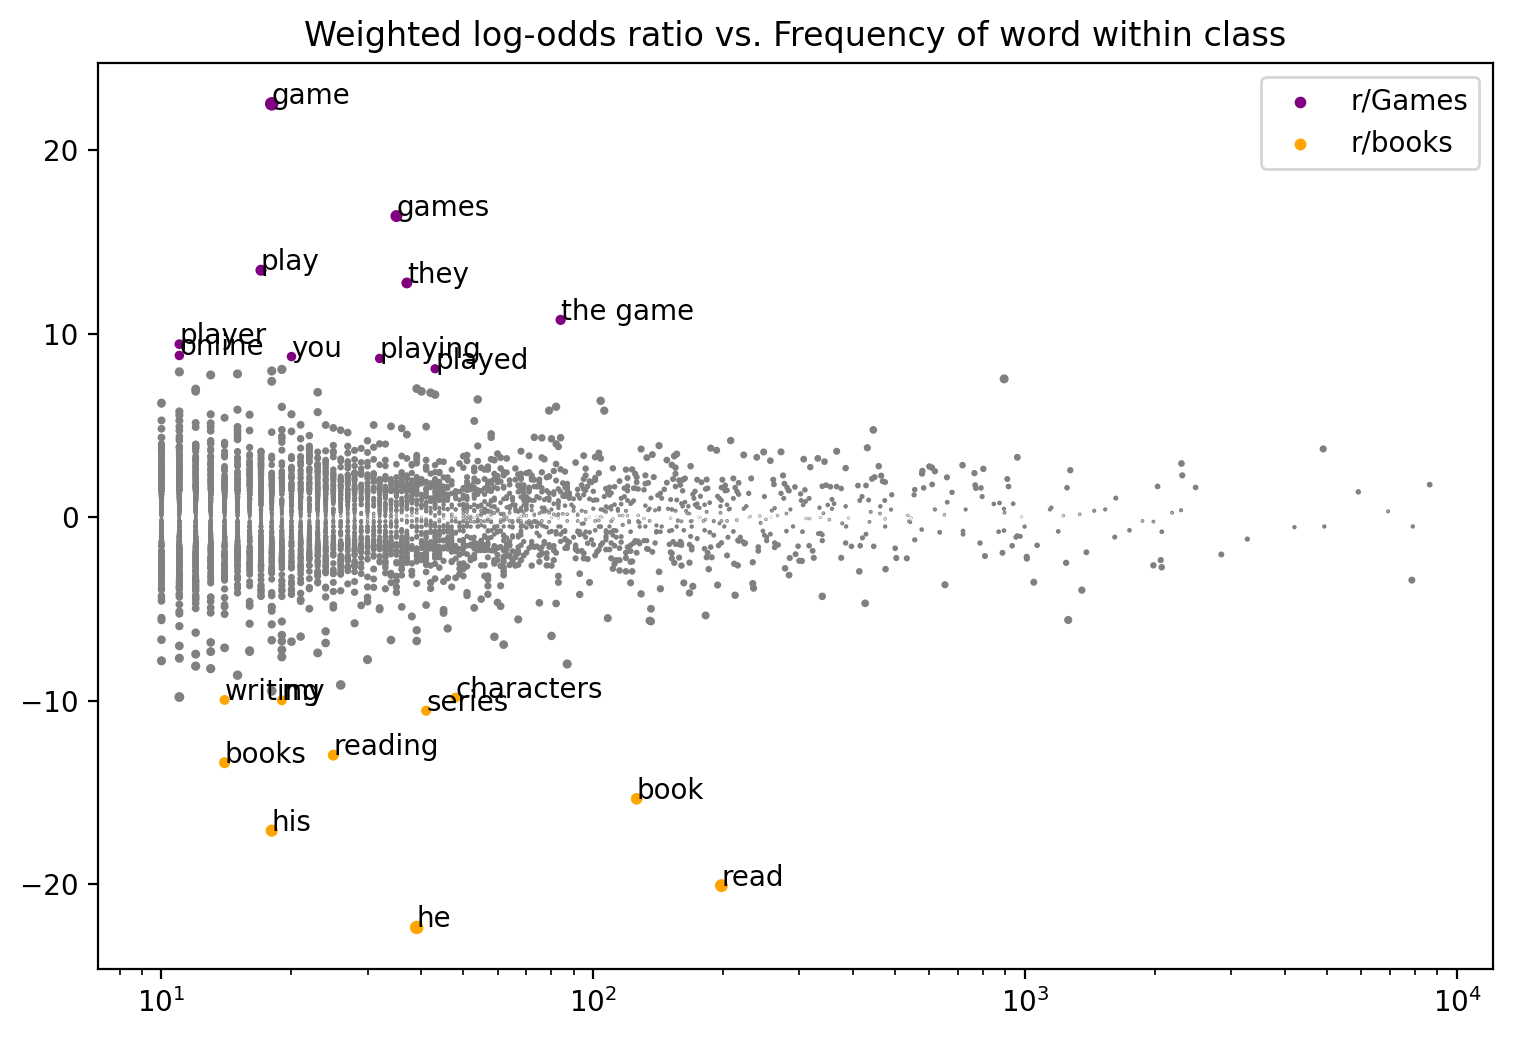

,z-score,class
ngram,,
he,-22.343564,r/books
read,-20.064671,r/books
his,-17.069173,r/books
book,-15.334499,r/books
books,-13.368149,r/books
...,...,...
the game,10.752777,r/Games
they,12.764946,r/Games
play,13.458495,r/Games


In [ ]:
#compare r/Games and r/books
fw.fit(corpus_1, class1_func = lambda utt: utt.meta['subreddit'] == 'Games',
       class2_func = lambda utt: utt.meta['subreddit'] == 'books')
fw.summarize(corpus_1, plot=True, class1_name='r/Games', class2_name='r/books')

class1_func returned 2387 valid corpus components. class2_func returned 2895 valid corpus components.
Vocab size is 3578
Comparing language...
ngram zscores computed.


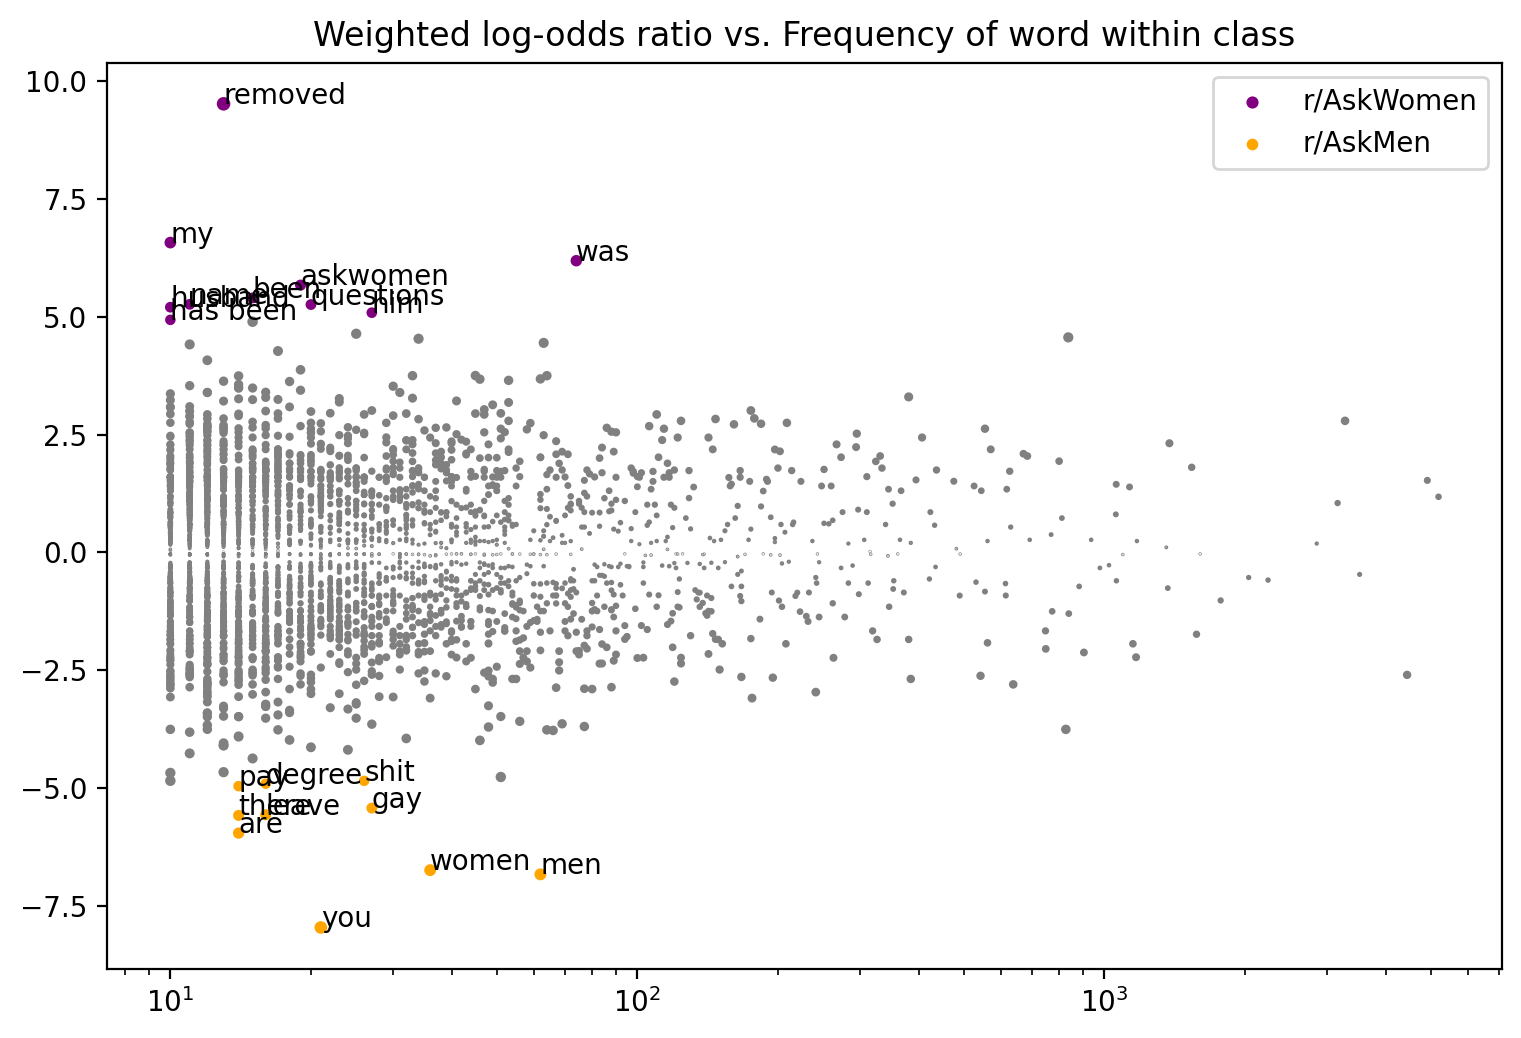

,z-score,class
ngram,,
you,-7.962239,r/AskMen
men,-6.834005,r/AskMen
women,-6.745194,r/AskMen
are,-5.958444,r/AskMen
there,-5.582949,r/AskMen
...,...,...
been,5.403464,r/AskWomen
askwomen,5.676058,r/AskWomen
was,6.194146,r/AskWomen


In [ ]:
#compare r/AskWomen and r/AskMen
fw.fit(corpus_1, class1_func = lambda utt: utt.meta['subreddit'] == 'AskWomen',
       class2_func = lambda utt: utt.meta['subreddit'] == 'AskMen')
fw.summarize(corpus_1, plot=True, class1_name='r/AskWomen', class2_name='r/AskMen')

class1_func returned 2533 valid corpus components. class2_func returned 1586 valid corpus components.
Vocab size is 2274
Comparing language...
ngram zscores computed.


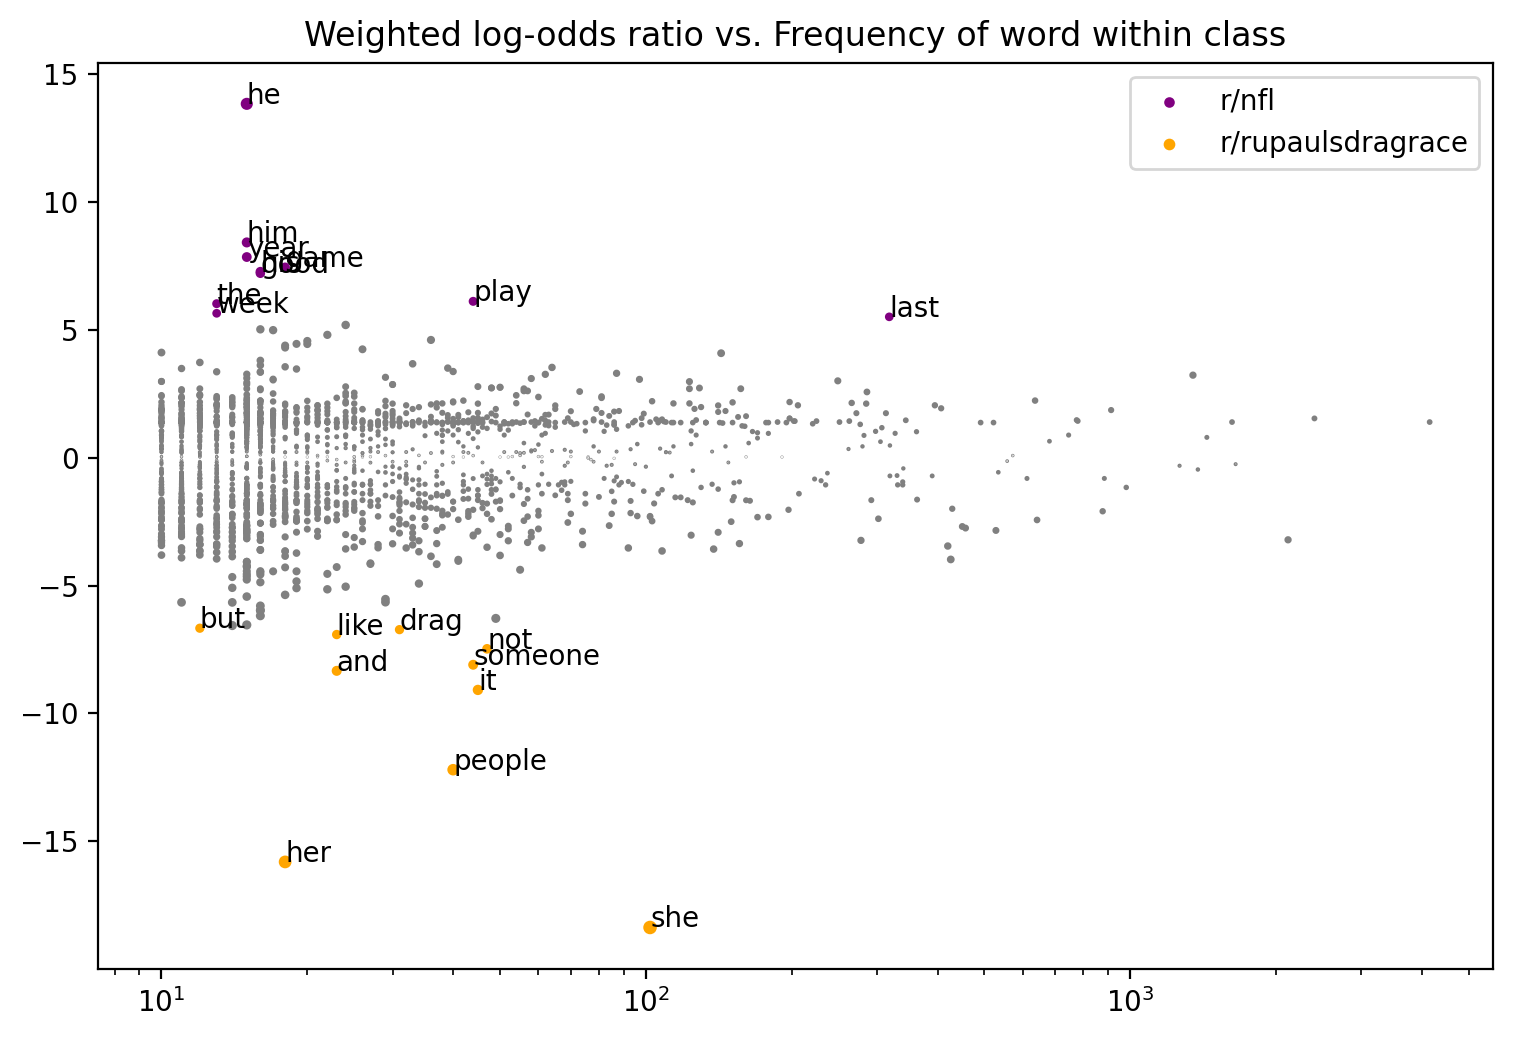

,z-score,class
ngram,,
she,-18.370105,r/rupaulsdragrace
her,-15.807324,r/rupaulsdragrace
people,-12.201261,r/rupaulsdragrace
it,-9.081737,r/rupaulsdragrace
and,-8.335852,r/rupaulsdragrace
...,...,...
his,7.272838,r/nfl
game,7.441381,r/nfl
year,7.844062,r/nfl


In [ ]:
#compare r/nfl and r/rupaulsdragrace
fw.fit(corpus_1, class1_func = lambda utt: utt.meta['subreddit'] == 'nfl',
       class2_func = lambda utt: utt.meta['subreddit'] == 'rupaulsdragrace')
fw.summarize(corpus_1, plot=True, class1_name='r/nfl', class2_name='r/rupaulsdragrace')

class1_func returned 1484 valid corpus components. class2_func returned 1645 valid corpus components.
Vocab size is 1347
Comparing language...
ngram zscores computed.


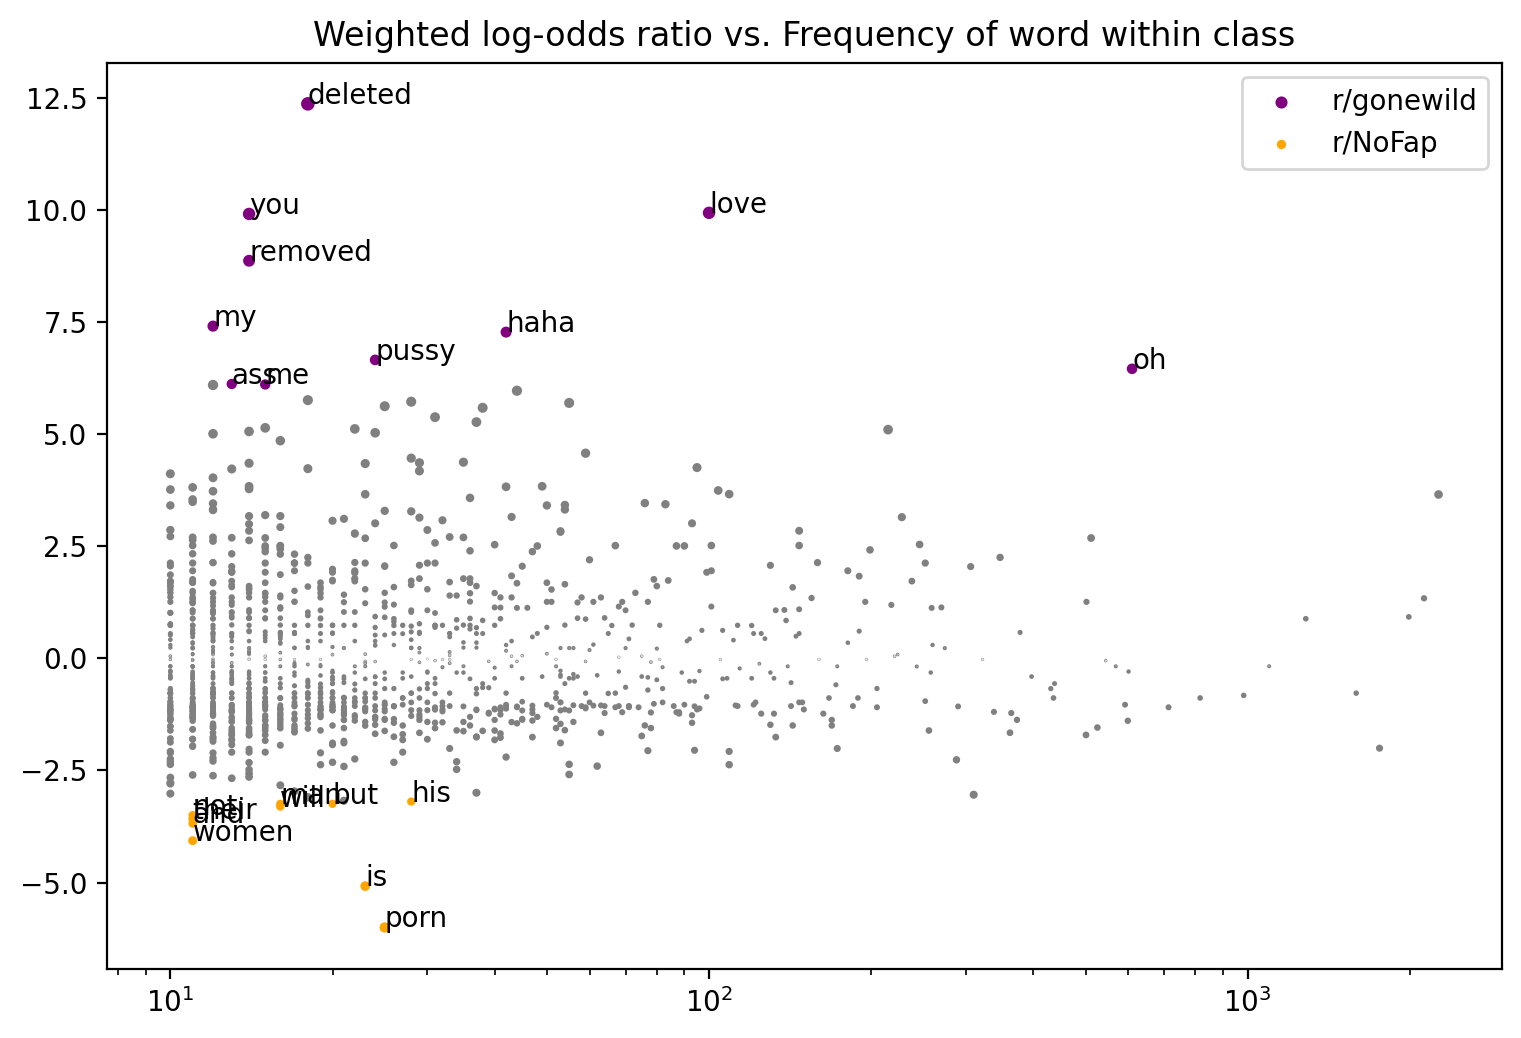

,z-score,class
ngram,,
porn,-6.001543,r/NoFap
is,-5.078945,r/NoFap
women,-4.065841,r/NoFap
and,-3.681116,r/NoFap
their,-3.580461,r/NoFap
...,...,...
my,7.408207,r/gonewild
removed,8.865948,r/gonewild
you,9.909835,r/gonewild


In [ ]:
#compare r/NoFap and r/gonewild
fw.fit(corpus_1, class1_func = lambda utt: utt.meta['subreddit'] == 'gonewild',
       class2_func = lambda utt: utt.meta['subreddit'] == 'NoFap')
fw.summarize(corpus_1, plot=True, class1_name='r/gonewild', class2_name='r/NoFap')

In [ ]:
#template
fw.fit(corpus_1, class1_func = lambda utt: utt.meta['subreddit'] == 'subreddit1',
       class2_func = lambda utt: utt.meta['subreddit'] == 'subreddit2')
fw.summarize(corpus_1, plot=True, class1_name='r/subreddit1', class2_name='r/subreddit2')

Interpretation: For the above exercise, I chose to compare conversations from several subreddits included in the subreddit small corpus. Comparing r/Games to r/books, we can see that, unsurprisingly, r/books features more reading-related works like read, writing, and books, whereas r/Gaming features more game-related words like player, online, and games. Comparing r/AskMen and r/AskWomen does not provide any particularly interesting insights. Comparing r/nfl and r/rupaulsdragrace, we can see that male pronouns are almost exclusive to r/nfl, while female and gender-neutral pronouns appear much more often in r/rupaulsdragrace. Finally, comparing r/gonewild and r/NoFap, I find it interesting that the word "porn" appears most exclusively in r/NoFap despite it being an anti-masturbation subreddit.

# Interactional influence

Before we utilize transformers, let's see how to estimate the influence of one speaker on another in order to estimate a kind of interpersonal influence network based on a recent paper by Fangjian Guo, Charles Blundell, Hanna Wallach, and Katherine Heller entitled ["The Bayesian Echo Chamber: Modeling Social Influence via Linguistic Accommodation"](https://arxiv.org/pdf/1411.2674.pdf). This relies on a kind of point process called a Hawkes process that estimate the influence of one point on another. Specifically, what they estimate is the degree to which one actor to an interpersonal interaction engaged in "accomodation" behaviors relative to the other, generating a directed edge from the one to the other.

### First let's look at the output of their analysis:

In [8]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [11]:
example_name = '12-angry-men'   #example datasets: "12-angry-men" or "USpresident"

In [13]:
result_path = '/content/drive/MyDrive/Homework-Notebooks/week-8/data/USpresident'.format(example_name)
#result_path = '../data/Bayesian-echo/results/{}/'.format(example_name)
if not os.path.isdir(result_path):
    raise ValueError('Invalid example selected, only "12-angry-men" or "USpresident" are avaliable')

In [15]:
result_path = '../data/Bayesian-echo/results/{}/'.format(example_name)

In [16]:
df_meta_info = pd.read_table(result_path + 'meta-info.txt',header=None)
df_log_prob = pd.read_csv(result_path + "SAMPLE-log_prior_and_log_likelihood.txt",delim_whitespace=True) #log_prob samples
df_influence = pd.read_csv(result_path + 'SAMPLE-influence.txt',delim_whitespace=True) # influence samples
df_participants = pd.read_csv(result_path + 'cast.txt', delim_whitespace=True)
person_id = pd.Series(df_participants['agent.num'].values-1,index=df_participants['agent.name']).to_dict()
print()
print ('Person : ID')
person_id

FileNotFoundError: ignored

In [17]:
def getDensity(df):
    data = df#_log_prob['log.prior']
    density = scipy.stats.gaussian_kde(data)
    width = np.max(data) - np.min(data)
    xs = np.linspace(np.min(data)-width/5, np.max(data)+width/5,600)
    density.covariance_factor = lambda : .25
    density._compute_covariance()
    return xs, density(xs)

### Plot MCMC (Markov Monte Carlo) trace and the density of log-likelihoods

In [ ]:
fig = plt.figure(figsize=[12,10])

plt.subplot(4,2,1)
plt.plot(df_log_prob['log.prior'])
plt.xlabel('Iterations')
plt.title('Trace of log.prior')

plt.subplot(4,2,2)
x,y = getDensity(df_log_prob['log.prior'])
plt.plot(x,y)
plt.xlabel('Iterations')
plt.title('Density of log.prior')

plt.subplot(4,2,3)
plt.plot(df_log_prob['log.likelihood'])
plt.title('Trace of log.likelihood')
plt.xlabel('Iterations')
plt.tight_layout()

plt.subplot(4,2,4)
x,y = getDensity(df_log_prob['log.likelihood'])
plt.plot(x,y)
plt.xlabel('Iterations')
plt.title('Density of log.likelihood')

plt.subplot(4,2,5)
plt.plot(df_log_prob['log.likelihood.test.set'])
plt.title('Trace of log.likelihood.test.set')
plt.xlabel('Iterations')
plt.tight_layout()

plt.subplot(4,2,6)
x,y = getDensity(df_log_prob['log.likelihood.test.set'])
plt.plot(x,y)
plt.xlabel('Iterations')
plt.title('Density of log.likelihood.test.set')

plt.subplot(4,2,7)
plt.plot(df_log_prob['log.prior']+df_log_prob['log.likelihood'])
plt.title('Trace of log.prob')
plt.xlabel('Iterations')

plt.subplot(4,2,8)
x,y = getDensity(df_log_prob['log.prior']+df_log_prob['log.likelihood'])
plt.plot(x,y)
plt.xlabel('Iterations')
plt.title('Density of log.prob')

plt.tight_layout()

plt.show()

### Plot the influence matrix between participants

In [ ]:
A = int(np.sqrt(len(df_influence.columns))) #number of participants
id_person = {}
for p in person_id:
    id_person[person_id[p]]=p

In [ ]:
def getmatrix(stacked,A):
    influence_matrix = [[0 for i in range(A)] for j in range(A)]
    for row in stacked.iteritems():
        from_ = int(row[0].split('.')[1])-1
        to_ = int(row[0].split('.')[2])-1
        value = float(row[1])
        influence_matrix[from_][to_]=value
    df_ = pd.DataFrame(influence_matrix) 
    
    df_ =df_.rename(index = id_person)
    df_ =df_.rename(columns = id_person)
    return df_

In [ ]:
stacked = df_influence.mean(axis=0)
df_mean = getmatrix(stacked,A)

stacked = df_influence.std(axis=0)
df_std = getmatrix(stacked,A)

In [ ]:
df_mean

In [ ]:
f, ax = plt.subplots(figsize=(9, 6))
seaborn.heatmap(df_mean, annot=True,  linewidths=.5, ax=ax,cmap="YlGnBu")
print('MEAN of influence matrix (row=from, col=to)')
plt.show()

In [ ]:
f, ax = plt.subplots(figsize=(9, 6))
seaborn.heatmap(df_std, annot=True,  linewidths=.5, ax=ax,cmap="YlGnBu")
print('SD of influence matrix (row=from, col=to)')
plt.show()

### Barplot of total influences sent/received

In [ ]:
sender_std = {} #sd of total influence sent
reciever_std = {} #sd of total influence recieved
for i in range(A):
    reciever_std[id_person[i]] = df_influence[df_influence.columns[i::A]].sum(axis=1).std()
    sender_std[id_person[i]] = df_influence[df_influence.columns[i*A:(i+1)*A:]].sum(axis=1).std()

sent = df_mean.sum(axis=1) #mean of total influence sent
recieved =df_mean.sum(axis=0) #mean of total influence recieved

Total influence:

In [ ]:
print ("\t\tTotal linguistic influence sent/received ")
ax.fig = plt.figure(figsize=[np.min([A,20]),6])

plt.grid()
wd=0.45
ii=0
for p in sender_std:
    plt.bar(person_id[p],sent.loc[p],width=wd,color='red',alpha=0.6,label = "Sent" if ii == 0 else "")
    plt.plot([person_id[p]-wd/4,person_id[p]+wd/4],[sent.loc[p]+sender_std[p],sent.loc[p]+sender_std[p]],color='k')
    plt.plot([person_id[p]-wd/4,person_id[p]+wd/4],[sent.loc[p]-sender_std[p],sent.loc[p]-sender_std[p]],color='k')
    plt.plot([person_id[p],person_id[p]],[sent.loc[p]-sender_std[p],sent.loc[p]+sender_std[p]],color='k')
    ii+=1
ii=0
for p in reciever_std:
    plt.bar(person_id[p]+wd,recieved.loc[p],width=wd,color='blue',alpha=0.4,label = "Received" if ii == 0 else "")
    plt.plot([person_id[p]+wd-wd/4,person_id[p]+wd+wd/4],[recieved.loc[p]+reciever_std[p],recieved.loc[p]+reciever_std[p]],color='k')
    plt.plot([person_id[p]+wd-wd/4,person_id[p]+wd+wd/4],[recieved.loc[p]-reciever_std[p],recieved.loc[p]-reciever_std[p]],color='k')
    plt.plot([person_id[p]+wd,person_id[p]+wd],[recieved.loc[p]-reciever_std[p],recieved.loc[p]+reciever_std[p]],color='k')
    ii+=1
plt.legend(loc='center left', bbox_to_anchor=(1, 0.7))
plt.xticks([i+0.25 for i in range(A)],list(zip(*sorted(id_person.items())))[1])
plt.ylabel('value')
plt.xlabel('speaker',fontsize=14)
plt.show()

## Visualize Influence Network!

You can visualize any of the influence matrices above:

Using networkx:

In [ ]:
def drawNetwork(df,title):
    fig = plt.figure(figsize=[8,8])
    G = nx.DiGraph()
    for from_ in df.index:
        for to_ in df.columns:
            G.add_edge(from_,to_,weight = df.loc[from_][to_])
            
    pos = nx.spring_layout(G,k=0.55,iterations=20)
    edges,weights = zip(*nx.get_edge_attributes(G,'weight').items())
    weights = np.array(weights)
    #weights = weights*weights
    weights = 6*weights/np.max(weights)
    print(title)
    
    edge_colors=20*(weights/np.max(weights))
    edge_colors = edge_colors.astype(int)
#     nx.draw_networkx_nodes(G,pos,node_size=1200,alpha=0.7,node_color='#99cef7')
#     nx.draw_networkx_edges(G,pos,edge_color=edge_colors)
#     nx.draw_networkx_labels(G,pos,font_weight='bold')
    nx.draw(G,pos,with_labels=True, font_weight='bold',width=weights,\
            edge_color=255-edge_colors,node_color='#99cef7',node_size=1200,\
            alpha=0.75,arrows=True,arrowsize=20)
    return edge_colors

In [ ]:
# get quantile influence matrices for 25%, 50%, 75% quantile
stacked = df_influence.quantile(0.25)
df_q25 = getmatrix(stacked,A)

stacked = df_influence.quantile(0.5)
df_q50 = getmatrix(stacked,A)

stacked = df_influence.quantile(0.75)
df_q75 = getmatrix(stacked,A)

In [ ]:
G_mean = drawNetwork(df_mean,'Mean Influence Network')

In [ ]:
G_q25 = drawNetwork(df_q25,'25 Quantile Influence Network')

In [ ]:
G_q75 = drawNetwork(df_q75,'75 Quantile Influence Network')

In [ ]:
def fakeEnglish(length):
    listd=['a','b','c','d','e','f','g','s','h','i','j','k','l']
    return ''.join(np.random.choice(listd,length))

Your own dataset should contains 4 columns (with the same column names) as the artificial one below:

- name: name of the participant
- tokens: a list of tokens in one utterance
- start: starting time of utterance (unit doesn't matter, can be 'seconds','minutes','hours'...)
- end: ending time of utterance (same unit as start)

There is no need to sort data for the moment.

Below, we generate a fake collection of data from "Obama", "Trump", "Clinton"...and other recent presidents. You can either create your own simulation OR (better), add real interactional data from a online chat forum, comment chain, or transcribed from a conversation.

In [ ]:
script= []
language = 'eng' #parameter, no need to tune if using English, accept:{'eng','chinese'}
role = 'Adult' #parameter, no need to tune 

for i in range(290):
    dt = []
    dt.append(np.random.choice(['Obama','Trump','Clinton','Bush','Reagan','Carter','Ford','Nixon','Kennedy','Roosevelt']))
    faketokens = [fakeEnglish(length = 4) for j in range(30)]
    dt.append(faketokens) #fake utterance
    dt.append(i*2+np.random.random()) # start time
    dt.append(i*2+1+np.random.random()) # end time
    script.append(dt)

df_transcript = pd.DataFrame(script,columns=['name','tokens','start','end']) #"start", "end" are timestamps of utterances, units don't matter
df_transcript[:2]

Transform data into TalkbankXML format:

In [ ]:
output_fname = 'USpresident.xml'  #should be .xml
language = 'eng' 
#language = 'chinese'
lucem_illud.make_TalkbankXML(df_transcript, output_fname, language = language )

Run Bayesian Echo Chamber to get estimation.

- It may take a couple of hours. ( About 4-5 hours if Vocab_size=600 and sampling_time =2000)
- Larger "Vocab_size" (see below) will cost more time
- Larger "sampling_time" will also consume more time

In [ ]:
Vocab_size = 90 # up to Vocab_size most frequent words will be considered, it should be smaller than the total vocab
sampling_time = 1500  #The times of Gibbs sampling sweeps  (500 burn-in not included)
lucem_illud.bec_run(output_fname, Vocab_size, language, sampling_time)

## <font color="red">*Exercise 2*</font>

<font color="red">Construct cells immediately below this that perform a similar social similarity or influence analysis on a dataset relevant to your final project (__or one from ConvoKit__). Create relationships between actors in a network based on your dataset (e.g., person to person or document to document), and perform analyses that interrogate the structure of their interactions, similarity, and/or influence on one another. (For example, if relevant to your final project, you could explore different soap operas, counting how many times a character may have used the word love in conversation with another character, and identify if characters in love speak like each other. Or do opposites attract?) What does that analysis and its output reveal about the relative influence of each actor on others? What does it reveal about the social game being played?

<font color="red">Stretch 1:
Render the social network with weights (e.g., based on the number of scenes in which actors appear together), then calculate the most central actors in the show.Realtime output can be viewed in shell.

<font color="red">Stretch 2:
Implement more complex measures of similarity based on the papers you have read.

In [ ]:
!pip install convokit
from convokit import Corpus, download
corpus2 = Corpus(filename=download("supreme-2019"))
#corpus = Corpus(filename=download("wiki-corpus"))

In [ ]:
#load corpus
#corpus = Corpus(download('reddit-corpus-small'))

Dataset already exists at /root/.convokit/downloads/reddit-corpus-small


In [ ]:
dir(corpus2)
#df_meta_info = pd.read_table(corpus + 'meta-info.txt',header=None)

In [18]:
result_path = '/content/drive/MyDrive/Homework-Notebooks/data/Bayesian-echo/results'.format(example_name)
if not os.path.isdir(result_path):
    raise ValueError('Invalid example selected, only "12-angry-men" or "USpresident" are avaliable')

In [19]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [20]:
df_meta_info = pd.read_table(result_path + 'meta-info.txt',header=None)
df_log_prob = pd.read_csv(result_path + "SAMPLE-log_prior_and_log_likelihood.txt",delim_whitespace=True) #log_prob samples
df_influence = pd.read_csv(result_path + 'SAMPLE-influence.txt',delim_whitespace=True) # influence samples
df_participants = pd.read_csv(result_path + 'cast.txt', delim_whitespace=True)
person_id = pd.Series(df_participants['agent.num'].values-1,index=df_participants['agent.name']).to_dict()
print()
print ('Person : ID')
person_id

FileNotFoundError: ignored

In [21]:
def getDensity(df):
    data = df#_log_prob['log.prior']
    density = scipy.stats.gaussian_kde(data)
    width = np.max(data) - np.min(data)
    xs = np.linspace(np.min(data)-width/5, np.max(data)+width/5,600)
    density.covariance_factor = lambda : .25
    density._compute_covariance()
    return xs, density(xs)

NameError: ignored

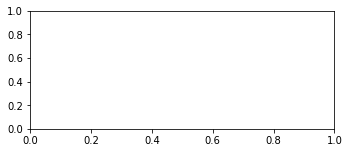

In [22]:
fig = plt.figure(figsize=[12,10])

plt.subplot(4,2,1)
plt.plot(df_log_prob['log.prior'])
plt.xlabel('Iterations')
plt.title('Trace of log.prior')

plt.subplot(4,2,2)
x,y = getDensity(df_log_prob['log.prior'])
plt.plot(x,y)
plt.xlabel('Iterations')
plt.title('Density of log.prior')

plt.subplot(4,2,3)
plt.plot(df_log_prob['log.likelihood'])
plt.title('Trace of log.likelihood')
plt.xlabel('Iterations')
plt.tight_layout()

plt.subplot(4,2,4)
x,y = getDensity(df_log_prob['log.likelihood'])
plt.plot(x,y)
plt.xlabel('Iterations')
plt.title('Density of log.likelihood')

plt.subplot(4,2,5)
plt.plot(df_log_prob['log.likelihood.test.set'])
plt.title('Trace of log.likelihood.test.set')
plt.xlabel('Iterations')
plt.tight_layout()

plt.subplot(4,2,6)
x,y = getDensity(df_log_prob['log.likelihood.test.set'])
plt.plot(x,y)
plt.xlabel('Iterations')
plt.title('Density of log.likelihood.test.set')

plt.subplot(4,2,7)
plt.plot(df_log_prob['log.prior']+df_log_prob['log.likelihood'])
plt.title('Trace of log.prob')
plt.xlabel('Iterations')

plt.subplot(4,2,8)
x,y = getDensity(df_log_prob['log.prior']+df_log_prob['log.likelihood'])
plt.plot(x,y)
plt.xlabel('Iterations')
plt.title('Density of log.prob')

plt.tight_layout()

plt.show()

INTERPRETATION: I tried to apply the above code to the SCOTUS dataset but couldn't get it to work. If I had gotten it to work, it might have shown that plaintiffs and advocates are more on the periphery of these relationships, while SCOTUS justices are at the center. I also assume that there might have been a divide between liberal and conservative justices and a grouping of each.

## Text Generation using GPT-2 and BERT

We can make use of the transformers we learned about last week to do text generation, where the model takes one or multiple places in a conversation. While some may regard it as a parlour trick due to unpredictability, recent dramatic improvements in text generation suggest that these kind of models can find themselves being used in more serious social scientific applications, such as in survey design and construction, idiomatic translation, and the normalization of phrase and sentence meanings.

These models can be quite impressive, even uncanny in how human like they sound. Check out this [cool website](https://transformer.huggingface.co), which allows you to write with a transformer. The website is built by the folks who wrote the package we are using. The code underneath the website can be found in their examples: [run_generation.py](https://github.com/huggingface/transformers/blob/master/examples/run_generation.py).

We will be using the built in generate function, but the example file has more detailed code which allows you to set the seed differently.

In [ ]:
from transformers import AutoModelWithLMHead, AutoTokenizer

tokenizer_gpt = AutoTokenizer.from_pretrained("gpt2")
model_gpt = AutoModelWithLMHead.from_pretrained("gpt2")

Downloading:   0%|          | 0.00/1.29M [00:00<?, ?B/s]

In [ ]:
sequence = "Nothing that we like to do more than analyse data all day long and"

input = tokenizer_gpt.encode(sequence, return_tensors="pt")
generated = model_gpt.generate(input, max_length=50)

resulting_string = tokenizer_gpt.decode(generated.tolist()[0])
print(resulting_string)

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Nothing that we like to do more than analyse data all day long and then try to figure out what's going on.

"We're not going to be able to do that. We're not going to be able to do that. We


Wow. A little creepy, and as we can see, far from perfect: GPT doesn't alwats work out flawlessly, but it sometimes can, and we will try and see if fine-tuning helps. We are going to tune the model on a complete dataset of Trump tweets, as they have a set of distinctive, highly identifiable qualities.

### Creating a domain-specific language model

One of the most exciting things about BERT and GPT is being able to retune them the way we want to. We will be training models to perform two tasks - one is to create a BERT with an "accent", by traning a model with english news data from the UK, from the US, and from India. We will also train a language generation model with a bunch of Trump tweets. 

We can train models specifically over a certain domain to make its language generation similar to that domain. 
[run_language modelling.py](https://github.com/huggingface/transformers/blob/master/examples/run_language_modeling.py), followed by [run_generation.py](https://github.com/huggingface/transformers/blob/master/examples/run_generation.py). I've downloaded these files and added them to this directory so we can run them through the notebook. You are encouraged to look at these files to get a rough idea of what is going on.

### Loading Data 

We want to now get our Trump tweets and our English news datasets ready. The data the scripts expect is just a text file with relevant data. We load the Trump tweets and then write them to disk as train and test files with only data. I leave the original dataframes in case you would like to use it for your own purposes.

In [ ]:
dfs = []

In [ ]:
for file in os.listdir("/content/drive/MyDrive/Homework-Notebooks/data/trump_tweets"):
    dfs.append(pd.read_json("/content/drive/MyDrive/Homework-Notebooks/data/trump_tweets" + file))

ValueError: ignored

In [ ]:
#df = pd.concat(dfs)
#df = corpus

In [ ]:
scotus_corpus2 = Corpus(filename=download("supreme-2019"))

Dataset already exists at /root/.convokit/downloads/supreme-2019


In [ ]:
scotus_corpus2.get_utterances_dataframe()

,timestamp,text,speaker,reply_to,conversation_id,meta.case_id,meta.start_times,meta.stop_times,meta.speaker_type,meta.side,meta.timestamp,vectors
id,,,,,,,,,,,,
24929__0_000,None,"We'll hear argument next in Case 18-877, Allen...",j__john_g_roberts_jr,None,24929,2019_18-877,[0.0],[6.84],J,None,0.0,[]
24929__0_001,None,"Mr. Chief Justice, and may it please the Court...",derek_l_shaffer,24929__0_000,24929,2019_18-877,"[6.84, 18.52, 49.56, 57.96, 74.16, 78.68, 92.8...","[18.52, 49.56, 57.96, 74.16, 78.68, 92.84, 108...",A,1,6.84,[]
24929__0_002,None,All -- all that is -- would be highly persuasi...,j__ruth_bader_ginsburg,24929__0_001,24929,2019_18-877,"[137.96, 148.36, 150.28, 151.88]","[148.36, 150.28, 151.88, 154.64]",J,None,137.96,[]
24929__0_003,None,"Correct, Justice Ginsburg.\nBut -- but the Cou...",derek_l_shaffer,24929__0_002,24929,2019_18-877,"[154.64, 155.72, 157.76, 159.64, 168.04, 169.0...","[155.72, 157.76, 159.64, 168.04, 169.08, 183.0...",A,1,154.64,[]
24929__0_004,None,In -- in --,j__ruth_bader_ginsburg,24929__0_003,24929,2019_18-877,[200.88],[200.92],J,None,200.88,[]
...,...,...,...,...,...,...,...,...,...,...,...,...
24969__2_007,None,-- has all sorts of meaning that you're not en...,j__sonia_sotomayor,24969__2_006,24969,2019_19-67,"[3496.8, 3500.32, 3502.96, 3504.68]","[3500.32, 3502.96, 3504.68, 3506.04]",J,None,3496.8,[]
24969__2_008,None,"No, Your Honor --",eric_j_feigin,24969__2_007,24969,2019_19-67,[3506.04],[3506.56],A,1,3506.04,[]
24969__2_009,None,-- altogether?,j__sonia_sotomayor,24969__2_008,24969,2019_19-67,[3506.56],[3507.76],J,None,3506.56,[]


In [ ]:
df = scotus_corpus2.get_utterances_dataframe()

In [ ]:
df.head()

,timestamp,text,speaker,reply_to,conversation_id,meta.case_id,meta.start_times,meta.stop_times,meta.speaker_type,meta.side,meta.timestamp,vectors
id,,,,,,,,,,,,
24929__0_000,None,"We'll hear argument next in Case 18-877, Allen...",j__john_g_roberts_jr,None,24929,2019_18-877,[0.0],[6.84],J,None,0.0,[]
24929__0_001,None,"Mr. Chief Justice, and may it please the Court...",derek_l_shaffer,24929__0_000,24929,2019_18-877,"[6.84, 18.52, 49.56, 57.96, 74.16, 78.68, 92.8...","[18.52, 49.56, 57.96, 74.16, 78.68, 92.84, 108...",A,1,6.84,[]
24929__0_002,None,All -- all that is -- would be highly persuasi...,j__ruth_bader_ginsburg,24929__0_001,24929,2019_18-877,"[137.96, 148.36, 150.28, 151.88]","[148.36, 150.28, 151.88, 154.64]",J,None,137.96,[]
24929__0_003,None,"Correct, Justice Ginsburg.\nBut -- but the Cou...",derek_l_shaffer,24929__0_002,24929,2019_18-877,"[154.64, 155.72, 157.76, 159.64, 168.04, 169.0...","[155.72, 157.76, 159.64, 168.04, 169.08, 183.0...",A,1,154.64,[]
24929__0_004,None,In -- in --,j__ruth_bader_ginsburg,24929__0_003,24929,2019_18-877,[200.88],[200.92],J,None,200.88,[]


In [ ]:
from sklearn.model_selection import train_test_split
train_text, test_text = train_test_split(df['text'], test_size=0.2)

In [ ]:
#from sklearn.model_selection import train_test_split
#train_text, test_text = train_test_split(smalldf['speechContent'], test_size=0.2)

In [ ]:
train_text.head()

id
25044__0_032    Have you ever heard of a case brought under th...
24958__2_034                                              Well --
24929__0_091    Well, we think that there's still an Article I...
25042__2_049    And there is different kinds of non-mandatory ...
24971__2_109    I -- I'm not sure if I heard you right.\nAll -...
Name: text, dtype: object

In [ ]:
train_text.to_frame().to_csv(r'train_text_trump', header=None, index=None, sep=' ', mode='a')

In [ ]:
test_text.to_frame().to_csv(r'test_text_trump', header=None, index=None, sep=' ', mode='a')

I now used the Google Colab GPUs to train the Trump tweet models. We'll be doing the same for our blog posts too.

### GloWBe dataset

We'll now load up the GloWbe (Corpus of Global Web-Based English) dataset which have different texts from different countries. We'll try and draw out texts from only the US, UK and India. We'll then save these to disk. Note that this is a Davies Corpora dataset: the full download can be done with the Dropbox link I sent in an announcement a few weeks ago. The whole download is about 3.5 GB but we only need two files, which are anout 250 MB each. The other files might be useful for your research purposes.

In [ ]:
address = "C:/Downloads/GloWbE"

In [ ]:
# these are the exact name of the files
us = "/text_us_blog_jfy.zip"
gb = "/text_gb_blog_akq.zip"

In [ ]:
us_texts = lucem_illud.loadDavies(address, corpus_style="us_blog", num_files=5000)

In [ ]:
gb_texts = lucem_illud.loadDavies(address, corpus_style="gb_blog", num_files=5000)

We now have a dictionary with document ids mapping to text. Since we don't need any information but the text, we can just save these to disk.

In [ ]:
' '.join(list(us_texts.values())[10])

In [ ]:
def dict_to_texts(texts, file_name):
    text = []
    for doc in list(texts.values()):
        text.append(' '.join(doc).replace("< h >", "").replace("< p >", ""))
    train_text, test_text = train_test_split(text, test_size=0.2)
    with open(file_name + "_train", 'w') as f:
        for item in train_text:
            f.write("%s\n" % item)
    
    with open(file_name + "_test", 'w') as f:
        for item in test_text:
            f.write("%s\n" % item)

In [ ]:
dict_to_texts(us_texts, "us_blog")

In [ ]:
dict_to_texts(gb_texts, "gb_blog")

We now have the training and testing files for both US and GB blogs in English. 

(WARNING - SHIFT TO GOOGLE COLAB OR GPU ENABLED MACHINE)


### Running Scripts

We use the scripts to do language modelling and text generation. The following cells run the code as if you would have run it in a terminal.

#### Trump GPT-2

In [ ]:
for file in os.listdir("drive/MyDrive/SOCI40133/Homework-Notebooks/data/trump_tweets"):
    dfs.append(pd.read_json("drive/MyDrive/SOCI40133/Homework-Notebooks/data/trump_tweets/" + file))

In [ ]:
# You might have issues with the memory of your GPU in the following code.
# The default Google Colab GPU should work with batch size of 2,
# but if you get a "CUDA out of memory" error, you can reduce it to 1.
# The default is 4 if you have a large GPU.

# !python run_language_modeling.py --per_gpu_train_batch_size=1 --output_dir=output_gpt_trump --model_type=gpt2 --model_name_or_path=gpt2 --do_train --train_data_file=train_text_trump --do_eval --eval_data_file=test_text_trump
!python run_language_modeling.py --per_gpu_train_batch_size=2 --output_dir=output_gpt_trump --model_type=gpt2 --model_name_or_path=gpt2 --do_train --train_data_file=train_text_trump --do_eval --eval_data_file=test_text_trump
# !python run_language_modeling.py --output_dir=output_gpt_trump --model_type=gpt2 --model_name_or_path=gpt2 --do_train --train_data_file=train_text_trump --do_eval --eval_data_file=test_text_trump

python3: can't open file 'run_language_modeling.py': [Errno 2] No such file or directory


In [ ]:
#!pip install transformers
!python /content/drive/MyDrive/Homework-Notebooks/week-8/run_language_modelling.py --per_gpu_train_batch_size=2 --output_dir=output_gpt_trump --model_type=gpt2 --model_name_or_path=gpt2 --do_train --train_data_file=train_text_trump --do_eval --eval_data_file=test_text_trump

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
03/03/2022 22:39:16 - WARNING - __main__ -   Process rank: -1, device: cuda, n_gpu: 1, distributed training: False, 16-bits training: False
03/03/2022 22:39:24 - INFO - __main__ -   Training/evaluation parameters Namespace(adam_epsilon=1e-08, block_size=1024, cache_dir='', config_name='', device=device(type='cuda'), do_eval=True, do_lower_case=False, do_train=True, eval_all_checkpoints=False, eval_data_file='test_text_trump', evaluate_during_training=False, fp16=False, fp16_opt_level='O1', gradient_accumulation_steps=1, learning_rate=5e-05, local_rank=-1, logging_steps=50, max_grad_norm=1.0, max_steps=-1, mlm=False, mlm_probability=0.15, model_name_or_path='gpt2', model_type='gpt2', n_gpu=1, no_cuda=False, num_train_epochs=1.0, num_warmup_steps=0, output_dir='output_gpt_trump', overwrite_cache=False, overwrite_output_dir=False, per_gpu_eval_batch_size=1, per_gpu_train_b

#### RoBERTa US

In [ ]:
!python run_language_modeling.py --output_dir=output_roberta_us --model_type=roberta --model_name_or_path=roberta-base --do_train --train_data_file=us_blog_train --do_eval --eval_data_file=us_blog_test --mlm

#### RoBERTa UK

In [ ]:
!python run_language_modeling.py --output_dir=output_roberta_gb --model_type=roberta --model_name_or_path=roberta-base --do_train --train_data_file=gb_blog_train --do_eval --eval_data_file=gb_blog_test --mlm

(If you left to use a GPU machine, COME BACK TO THIS NOTEBOOK to load and work with your trained model.)

### Loading and using models

Let us now load the four models we have and see how we can use them.

And now - let us see what our Trump Tweet Bot looks like!
You can generate text via command line using the command below. You can also load a model once it is saved - I trained my model using Google Colab, downloaded the model, and am loading it again via the command below. Note that you have to download all the files in your folder of the fine-tuned model to use the model.

In [ ]:
# !python run_generation.py --model_type=gpt2 --model_name_or_path=output_gpt_trump

In [ ]:
tokenizer_trump = AutoTokenizer.from_pretrained("output_gpt_trump")
model_trump = AutoModelWithLMHead.from_pretrained("output_gpt_trump")

In [ ]:
sequence = "Obama is going to"

input = tokenizer_trump.encode(sequence, return_tensors="pt")
generated = model_trump.generate(input, max_length=50, bos_token_id=1, pad_token_id=1, eos_token_ids=1)

resulting_string = tokenizer_trump.decode(generated.tolist()[0])
print(resulting_string)

Obama is going to have to do it in a way that's consistent with the Constitution, and that's going to be consistent with the Constitution's text.
And I think that's what the Court said in the first case, that the government has


Wow - our Trump bot is nasty, so we know our model trained well. What happens if we try the same sentence for our non-fine tuned model?

In [ ]:
sequence = "Obama is going to"

input = tokenizer_gpt.encode(sequence, return_tensors="pt")
generated = model_gpt.generate(input, max_length=50, bos_token_id=1, pad_token_id=1, eos_token_ids=1)

resulting_string = tokenizer_gpt.decode(generated.tolist()[0])
print(resulting_string)

Obama is going to be a very good president," said Sen. John McCain (R-Ariz.). "He's going to be a very good president. He's going to be a very good president. He's going to be a very good


Quite the contrast.

## <font color="red">*Exercise 3*</font>

<font color="red">Construct cells immediately below this that generate a BERT-powered chatbot tuned on text related to your final project. What is interesting about this model, and how to does it compare to an untrained model? What does it reveal about the social game involved with your dataset?

In [ ]:
#load corpus
scotus_corpus = Corpus(filename=download("supreme-2019"))

Dataset already exists at /root/.convokit/downloads/supreme-2019


In [ ]:
df = scotus_corpus.get_utterances_dataframe()

In [ ]:
from sklearn.model_selection import train_test_split
train_text, test_text = train_test_split(df['text'], test_size=0.2)
#train
train_text.to_frame().to_csv(r'train_text_trump', header=None, index=None, sep=' ', mode='a')
#test
test_text.to_frame().to_csv(r'test_text_trump', header=None, index=None, sep=' ', mode='a')

In [ ]:
from transformers import AutoModelWithLMHead, AutoTokenizer

tokenizer_gpt = AutoTokenizer.from_pretrained("gpt2")
model_gpt = AutoModelWithLMHead.from_pretrained("gpt2")

Downloading:   0%|          | 0.00/1.29M [00:00<?, ?B/s]

In [ ]:
#!pip install transformers
!python /content/drive/MyDrive/Homework-Notebooks/week-8/run_language_modelling.py --per_gpu_train_batch_size=2 --output_dir=output_gpt_scotus2 --model_type=gpt2 --model_name_or_path=gpt2 --do_train --train_data_file=train_text_trump --do_eval --eval_data_file=test_text_trump

03/04/2022 04:10:03 - WARNING - __main__ -   Process rank: -1, device: cuda, n_gpu: 1, distributed training: False, 16-bits training: False
03/04/2022 04:10:10 - INFO - __main__ -   Training/evaluation parameters Namespace(adam_epsilon=1e-08, block_size=1024, cache_dir='', config_name='', device=device(type='cuda'), do_eval=True, do_lower_case=False, do_train=True, eval_all_checkpoints=False, eval_data_file='test_text_trump', evaluate_during_training=False, fp16=False, fp16_opt_level='O1', gradient_accumulation_steps=1, learning_rate=5e-05, local_rank=-1, logging_steps=50, max_grad_norm=1.0, max_steps=-1, mlm=False, mlm_probability=0.15, model_name_or_path='gpt2', model_type='gpt2', n_gpu=1, no_cuda=False, num_train_epochs=1.0, num_warmup_steps=0, output_dir='output_gpt_scotus2', overwrite_cache=False, overwrite_output_dir=False, per_gpu_eval_batch_size=1, per_gpu_train_batch_size=2, save_steps=50, save_total_limit=None, seed=42, server_ip='', server_port='', tokenizer_name='', train_d

In [ ]:
from transformers import AutoTokenizer, AutoModelWithLMHead

tokenizer_scotus = AutoTokenizer.from_pretrained("output_gpt_scotus2")
model_scotus = AutoModelWithLMHead.from_pretrained("output_gpt_scotus2")

tokenizer_gpt = AutoTokenizer.from_pretrained("gpt2")
model_gpt = AutoModelWithLMHead.from_pretrained("gpt2")

In [ ]:
#SCOTUS Chatbot -- court example
sequence = "The Supreme Court of the United States is"

input = tokenizer_scotus.encode(sequence, return_tensors="pt")
generated = model_scotus.generate(input, max_length=50, bos_token_id=1, pad_token_id=1, eos_token_ids=1)

resulting_string = tokenizer_scotus.decode(generated.tolist()[0])
print(resulting_string)

The Supreme Court of the United States is not a party to the case.
It is a party to the case.
It is not a party to the case.
It is not a party to the case.
It is not a party


In [ ]:
#GPT2-Chatbot -- court example
sequence = "The Supreme Court of the United States is"

input = tokenizer_gpt.encode(sequence, return_tensors="pt")
generated = model_gpt.generate(input, max_length=50, bos_token_id=1, pad_token_id=1, eos_token_ids=1)

resulting_string = tokenizer_gpt.decode(generated.tolist()[0])
print(resulting_string)

The Supreme Court of the United States is not a court of law. It is a court of law. It is a court of law. It is a court of law. It is a court of law. It is a court of law. It


In [ ]:
#SCOTUS Chatbot -- Attitudes towards Parties
sequence = "Democrats are"

input = tokenizer_scotus.encode(sequence, return_tensors="pt")
generated = model_scotus.generate(input, max_length=50, bos_token_id=1, pad_token_id=1, eos_token_ids=1)

resulting_string = tokenizer_scotus.decode(generated.tolist()[0])
print(resulting_string)

Democrats are not going to be able to do that.
They're going to be able to do it in a way that's not going to be a distraction from the fact that the government is going to be able to do it in a way that


In [ ]:
#SCOTUS Chatbot -- Attitudes towards Parties
sequence = "Republicans are"

input = tokenizer_scotus.encode(sequence, return_tensors="pt")
generated = model_scotus.generate(input, max_length=50, bos_token_id=1, pad_token_id=1, eos_token_ids=1)

resulting_string = tokenizer_scotus.decode(generated.tolist()[0])
print(resulting_string)

Republicans are not going to be able to do that.
They're going to be able to do it in a way that's not going to be a distraction from the fact that the government is going to be able to do it in a way that


In [ ]:
#GPT2-Chatbot -- Attitudes towards Parties
sequence = "Democrats are"

input = tokenizer_gpt.encode(sequence, return_tensors="pt")
generated = model_gpt.generate(input, max_length=50, bos_token_id=1, pad_token_id=1, eos_token_ids=1)

resulting_string = tokenizer_gpt.decode(generated.tolist()[0])
print(resulting_string)

Democrats are also concerned about the impact of the Affordable Care Act on their health care.

"The Affordable Care Act has been a disaster for the American people," said Sen. Bernie Sanders (I-Vt.). "It's a disaster for


In [ ]:
#GPT2-Chatbot -- Attitudes towards Parties
sequence = "Republicans are"

input = tokenizer_gpt.encode(sequence, return_tensors="pt")
generated = model_gpt.generate(input, max_length=50, bos_token_id=1, pad_token_id=1, eos_token_ids=1)

resulting_string = tokenizer_gpt.decode(generated.tolist()[0])
print(resulting_string)

Republicans are not going to be able to get the votes they need to pass a bill that will make it easier for them to pass a bill that will make it easier for them to pass a bill that will make it easier for them to pass a bill


In [ ]:
#SCOTUS Chatbot -- Attitudes towards Communism
sequence = "Communism is"

input = tokenizer_scotus.encode(sequence, return_tensors="pt")
generated = model_scotus.generate(input, max_length=50, bos_token_id=1, pad_token_id=1, eos_token_ids=1)

resulting_string = tokenizer_scotus.decode(generated.tolist()[0])
print(resulting_string)

Communism is not a religion.
It's a religion that teaches that the state is the only authority that can do what it wants.
It's a religion that teaches that the state is the only authority that can do what it wants.



In [ ]:
#SCOTUS Chatbot -- Attitudes towards Fascism
sequence = "Fascism is"

input = tokenizer_scotus.encode(sequence, return_tensors="pt")
generated = model_scotus.generate(input, max_length=50, bos_token_id=1, pad_token_id=1, eos_token_ids=1)

resulting_string = tokenizer_scotus.decode(generated.tolist()[0])
print(resulting_string)

Fascism is not a religion.
It's a religion that teaches that the only way to be a good person is to be a good person.
And that's what the Constitution says.
And that's what the Constitution says.



In [ ]:
#GPT2-Chatbot -- Attitudes towards Communism
sequence = "Communism is"

input = tokenizer_gpt.encode(sequence, return_tensors="pt")
generated = model_gpt.generate(input, max_length=50, bos_token_id=1, pad_token_id=1, eos_token_ids=1)

resulting_string = tokenizer_gpt.decode(generated.tolist()[0])
print(resulting_string)

Communism is a movement that seeks to create a new world order based on the principles of freedom, justice, and equality. It is a movement that seeks to create a new world order based on the principles of equality, justice, and equality.



In [ ]:
#GPT2-Chatbot -- Attitudes towards Fascism
sequence = "Fascism is"

input = tokenizer_gpt.encode(sequence, return_tensors="pt")
generated = model_gpt.generate(input, max_length=50, bos_token_id=1, pad_token_id=1, eos_token_ids=1)

resulting_string = tokenizer_gpt.decode(generated.tolist()[0])
print(resulting_string)

Fascism is a form of racism, and it is a form of racism that is not only wrong, but also harmful.

The problem with racism is that it is not only wrong, but also harmful. It is a form of racism


In [ ]:
#SCOTUS Chatbot -- Testing less common words
sequence = "Gerontocracy is"

input = tokenizer_scotus.encode(sequence, return_tensors="pt")
generated = model_scotus.generate(input, max_length=50, bos_token_id=1, pad_token_id=1, eos_token_ids=1)

resulting_string = tokenizer_scotus.decode(generated.tolist()[0])
print(resulting_string)

Gerontocracy is a very different thing.
It's a very different thing from the Constitution.
It's a very different thing from the Constitution.
And it's a very different thing from the Constitution.
And it's a very different


In [ ]:
#GPT2-Chatbot -- Testing less common words
sequence = "Gerontocracy is"

input = tokenizer_gpt.encode(sequence, return_tensors="pt")
generated = model_gpt.generate(input, max_length=50, bos_token_id=1, pad_token_id=1, eos_token_ids=1)

resulting_string = tokenizer_gpt.decode(generated.tolist()[0])
print(resulting_string)

Gerontocracy is a political system that is based on the idea that the people are the most important people in the world. It is a system that is based on the idea that the people are the most important people in the world. It is a


In [ ]:
#SCOTUS Chatbot -- Abortion
sequence = "Abortion is"

input = tokenizer_scotus.encode(sequence, return_tensors="pt")
generated = model_scotus.generate(input, max_length=50, bos_token_id=1, pad_token_id=1, eos_token_ids=1)

resulting_string = tokenizer_scotus.decode(generated.tolist()[0])
print(resulting_string)

Abortion is a crime, and it's a crime that's not a crime in the United States.
It's a crime that's not a crime in the United States.
It's a crime that's not a crime in the United States


In [ ]:
#SCOTUS Chatbot -- Roe v. Wade
sequence = "Roe v. Wade is"

input = tokenizer_scotus.encode(sequence, return_tensors="pt")
generated = model_scotus.generate(input, max_length=50, bos_token_id=1, pad_token_id=1, eos_token_ids=1)

resulting_string = tokenizer_scotus.decode(generated.tolist()[0])
print(resulting_string)

Roe v. Wade is a case that has been around for a long time.
It's a case that has been around for a long time.
It's a case that has been around for a long time.
It's a case


In [ ]:
#GPT2-Chatbot -- Abortion
sequence = "Abortion is"

input = tokenizer_gpt.encode(sequence, return_tensors="pt")
generated = model_gpt.generate(input, max_length=50, bos_token_id=1, pad_token_id=1, eos_token_ids=1)

resulting_string = tokenizer_gpt.decode(generated.tolist()[0])
print(resulting_string)

Abortion is a crime that is punishable by death.

The law is based on the principle that a woman's life is at risk if she is pregnant.

The law states that a woman's life is at risk if she is pregnant


In [ ]:
#GPT2-Chatbot -- Roe v. Wade
sequence = "Roe v. Wade is"

input = tokenizer_gpt.encode(sequence, return_tensors="pt")
generated = model_gpt.generate(input, max_length=50, bos_token_id=1, pad_token_id=1, eos_token_ids=1)

resulting_string = tokenizer_gpt.decode(generated.tolist()[0])
print(resulting_string)

Roe v. Wade is a case in which the Supreme Court has held that the government has the right to compel a person to sign a document that it believes is a threat to national security. The government has a right to compel a person to sign


Interpretation: In the above chunks of code, I trained a GPT-2 text generator on the SCOTUS corpus from ConvoKit. The model does not work perfectly in my opinion, as with several prompts I gave the chatbot, the output was rather nonsensical. For example, when asked "Democrats are" and "Republicans are," the output is identical, which is not particularly helpful when trying to analyze SCOTUS' opinions on the different parties. Also, when fed with less common words, the chatbot does not return great answers. For example, when asked "Gerontocracy is," the answer is not telling us anything. On some questions, however, the chatbot returns interesting answers. The most interesting question I asked it, in my view, was the following set of inputs: "Communism is" and "Fascism is." The answer from the chatbot was rather negative regarding communism, and very positive regarding fascism. I wonder if this showcases underlying right-slanted bias among oral arguments in the Supreme Court.

Contextual models can also help us visualize how words in a sentence or different or similar to each other. We will try to construct sentences where words might mean different things in different countries - in the US, people might eat chips with salsa, but in the UK, chips are what Americans call french fries, and might eat it fried fish instead. 

In [ ]:
from transformers import RobertaConfig, RobertaModel, RobertaTokenizer

In [ ]:
roberta_us_model_embedding = RobertaModel.from_pretrained('roberta_us')

OSError: ignored

In [ ]:
roberta_us_tokenizer = RobertaTokenizer.from_pretrained('roberta_us')

In [ ]:
text = "Do you have your chips with fish or with salsa?" 

In [ ]:
text1 = "He went out in just his undershirt and pants." #pants are underwear in Britain; maybe closer to an undershirt
text2 = "His braces completed the outfit." #braces are suspenders (in Britain); maybe closer to an outfit
text3 = "Does your pencil have a rubber on it?" #rubber is an eraser in Britain); maybe closer to a pencil
text4 = "Was the bog closer to the forest or the house?" #bog is a toilen in Britain); maybe closer to a house
text5 = "Are you taking the trolley or the train to the grocery market" #trolley is a food carriage; possibly closer to a market

In [ ]:
import seaborn as sns

In [ ]:
def visualise_diffs(text, model, tokenizer):
    word_vecs = []
    for i in range(0, len(text.split())):
        word_vecs.append(word_vector(text, i, model, tokenizer))
    L = []
    for p in word_vecs:
        l = []
        for q in word_vecs:
            l.append(1 - cosine(p, q))
        L.append(l)
    M = np.array(L)
    fig = plt.figure()
    div = pd.DataFrame(M, columns = list(text.split()), index = list(text.split()))
    ax = sns.heatmap(div)
    plt.show()

In [ ]:
visualise_diffs(text, roberta_us_model_embedding, roberta_us_tokenizer)

In [ ]:
roberta_gb_model_embedding = RobertaModel.from_pretrained('roberta_gb')
roberta_gb_tokenizer = RobertaTokenizer.from_pretrained('roberta_gb')

In [ ]:
visualise_diffs(text, roberta_gb_model_embedding, roberta_gb_tokenizer)

## <font color="red">*Exercise 4*</font>

<font color="red">What's a research question relevant to your final project that would benefit from a generative or conversational model like GPT-2 or GPT-3? What task would you have it perform, and how would you evaluate the ouput?
    
<font color="red">_Stretch:_ Do it!

It would be interesting to train a generative or conversational model using the speeches given by members of parliament from different parties. One could ask it questions such as "How do you feel about Russia's current invasion of Ukraine" and it might yield interesting answers. For example, it would be interesting to see if the chatbots modeled on speeches of the former communist Die Linke, or the right-wing extremist AfD, are more loyal to the Russian state than those modeled on speeches given by members of parliament of more mainstream parties. I would evaluate the output comparatively, as the interesting part is how the chatbots compare.

# Optional: AI Dungeon
A fun way to explore the power of conversation and text generation is [AI Dungeon](https://play.aidungeon.io/main/newGame). If you select _Quick Start_, you can start a text adventure similar to the popular role-playing game Dungeons and Dragons, or the "choose your own adventure" books some of us boomers read as kids. AI Dungeon used to use GPT-2 but now uses GPT-3 to generate text in response to your actions. For example, you may begin with the prompt:

```
You are Jimmy, a wizard living in the kingdom of Larion. You have a staff and a spellbook. You finish your long journey and finally arrive at the ruin you've been looking for. You have come here searching for a mystical spellbook of great power called the book of essence. You look around and see a beautiful woman with raven hair and dark, sparkling eyes. She approaches you and asks you what you seek.

You are now before the one known as Raven.
```

You can respond with any text. I type, `I ask Raven, "What is the meaning of life?"`, to which AI Dungeon says:

```
Raven ponders the question for a moment, and then she answers. Raven says, "It is the pursuit of happiness." What is the pursuit of happiness?
```

I type, `I respond, "Happiness to me would be unearthing the treasures of the Kilarean Empire."`:

```
Raven looks at me and says, "Come with me and live out your one true life."

You go with Raven through many passages and up and down elevators.
```

Raven might be helping me unearth the treasures! Not bad!

There are a lot of tools like AI Dungeon being developed now with state-of-the-art language models. Now that you have some understanding of deep language models, you can better appreciate them—and perhaps design some of your own!